In [1]:
from frgpascal.system import build, ALL_WORKERS
from roboflo import System

Generate protocols

In [2]:
from frgpascal.experimentaldesign.tasks import *

In [3]:
absorber_solution = Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.25,
    )

In [4]:
methyl_acetate = Solution(
        solvent='MethylAcetate',
        labware='4mL_b_AntisolventTray',
        well='D1',
    )

In [5]:
spincoat_absorber = Spincoat(
        steps=[
            [3000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=20,
                time=-1,
                blow_out=True,
                # pre_mix = (5,50),
            ),
            Drop(
                solution=methyl_acetate,
                volume=50,
                time=22,
                reuse_tip=True,
                touch_tip=False,
                rate=100,
                pre_mix = (3,100),
                slow_travel=True
            )
        ],
    )

spincoat_passivant = Spincoat(
        steps=[
            [3000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=20,
                time=-1,
                blow_out=True,
                # pre_mix = (5,50),
            ),
            Drop(
                solution=methyl_acetate,
                volume=50,
                time=22,
                reuse_tip=True,
                touch_tip=False,
                rate=100,
                pre_mix = (3,100),
                slow_travel=True
            )
        ],
    )

In [6]:
anneal_absorber = Anneal(
        temperature=100, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate1'
    )

anneal_absorber2 = Anneal(
        temperature=125, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate2'
    )

anneal_passivation = Anneal(
        temperature=50, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate3'
    )

In [7]:
s1 = Sample(
    name='sample0',
    substrate='glass',
    worklist = [
        spincoat_absorber,
        anneal_absorber,
        Rest(180),
        anneal_passivation,
        Characterize()
    ],
    storage_slot = {'tray':'Tray1', 'slot':'A1'},
)

In [8]:
samples = [Sample(
    name=f'sample{i}',
    substrate='glass',
    worklist = [
        spincoat_absorber,
        anneal_absorber,
        Rest(180),
        spincoat_passivant,
        anneal_passivation,
        Characterize()
    ],
    storage_slot = {'tray':'Tray1', 'slot':'A1'},
) for i in range(20)]

In [9]:
s2 = Sample(
    name='sample3',
    substrate='glass',
    worklist = [
        spincoat_absorber,
        anneal_absorber2,
        Rest(180),
        anneal_passivation,
        Characterize()
    ],
    storage_slot = {'tray':'Tray1', 'slot':'A1'},
)

In [10]:
def class_to_worker(worker_class):
    for w in ALL_WORKERS.values():
        if isinstance(w, worker_class):
            return w
    raise Exception("Could not find a matching worker for class {}".format(worker_class))

def generate_protocol(sample:Sample, system:System, min_start:int = 0):
    tray = [w for w in system.workers if isinstance(w, Worker_Storage) and w.name == sample.storage_slot['tray']][0]
    # print(hotplate)

    for task in sample.worklist:
        corrected_workers = []
        for worker in task.workers:
            if worker in ALL_WORKERS.values():
                corrected_workers.append(worker)
            elif worker == Worker_Hotplate:
                corrected_workers.append([w for w in system.workers if isinstance(w, Worker_Hotplate) and w.name == task.hotplate][0])
            elif worker == Worker_Storage:
                corrected_workers.append(tray)
            else:
                corrected_workers.append(class_to_worker(worker))
        task.workers = corrected_workers
        task.sample = sample

    sample.protocol = system.generate_protocol(
        name=sample.name,
        worklist=sample.worklist,
        starting_worker=tray,
        ending_worker=tray,
        min_start = min_start
    )

260
solution status: FEASIBLE


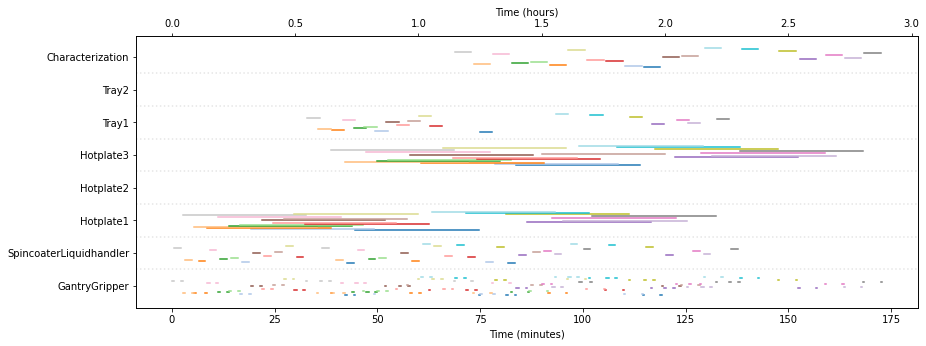

In [11]:
pascal = build()
for s in samples:
    generate_protocol(sample=s, system=pascal)
pascal.scheduler.solve(10, breakpoints = [])#[spincoat_absorber, Rest(180)])
pascal.scheduler.plot_solution()

120
intermediate solution status: FEASIBLE
previous solution still valid - add new protocols before solving again
120
intermediate solution status: FEASIBLE
260
solution status: FEASIBLE


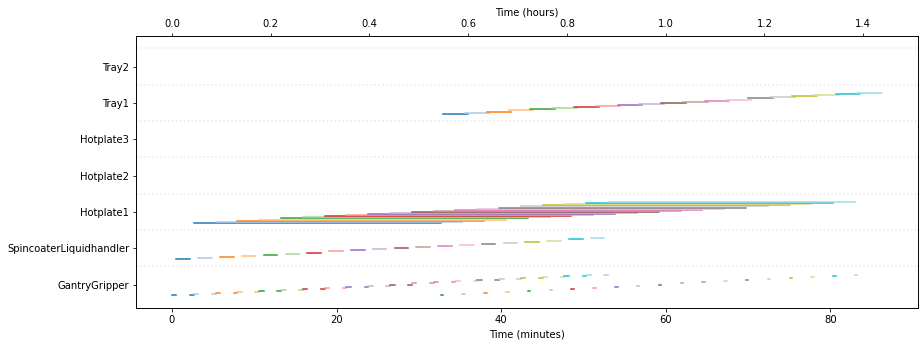

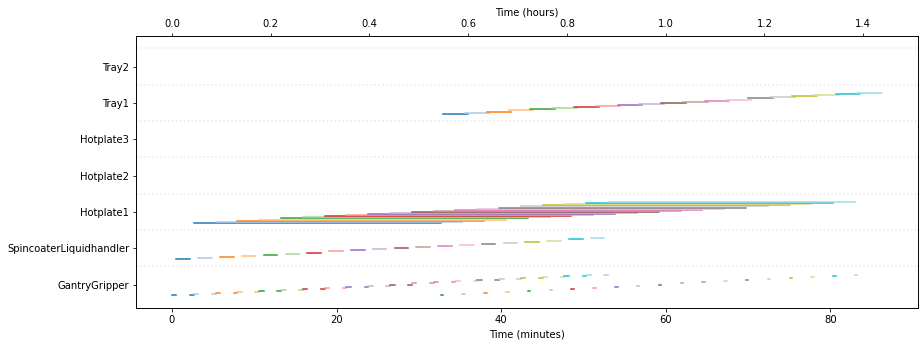

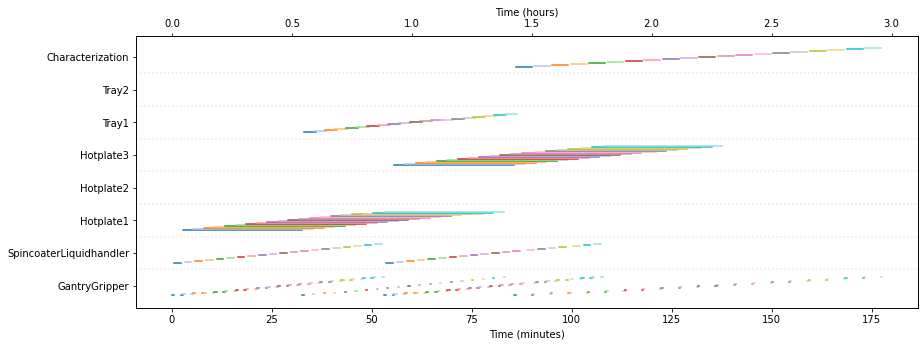

In [12]:
pascal = build()
for s in samples:
    generate_protocol(sample=s, system=pascal)
pascal.scheduler.solve(10, breakpoints = [spincoat_absorber])#[spincoat_absorber, Rest(180)])
pascal.scheduler.plot_solution()

In [13]:
task_sample_key = {}
for p in pascal.scheduler.protocols:
    for t in p.worklist:
        task_sample_key[t.id] = p.name
def append_sample(task_dict):
    task_dict['sample'] = task_sample_key[task_dict['id']]
    return task_dict

In [14]:
tasks = {worker.name: [append_sample(t.to_dict()) for t in tasklist] for worker, tasklist in pascal.scheduler.get_tasklist_by_worker().items()}

In [15]:
tasks

{'GantryGripper': [{'name': 'storage_to_spincoater',
   'start': 0,
   'id': 'storage_to_spincoater--84450733-85c2-48c0-8a82-d4bc7339e374',
   'details': {'source': 'Tray1', 'destination': 'SpincoaterLiquidhandler'},
   'precedent': None,
   'sample': 'sample0'},
  {'name': 'spincoater_to_hotplate',
   'start': 132,
   'id': 'spincoater_to_hotplate--a752c6a2-e9b0-4b82-94cf-5d49848a76ba',
   'details': {'source': 'SpincoaterLiquidhandler',
    'destination': 'Hotplate1'},
   'precedent': 'spincoat-ba90004c-9ab0-4764-bf87-104b8fd39a28',
   'sample': 'sample0'},
  {'name': 'storage_to_spincoater',
   'start': 159,
   'id': 'storage_to_spincoater--8a9c1b27-b8a1-4f05-b524-d362ea183e3f',
   'details': {'source': 'Tray1', 'destination': 'SpincoaterLiquidhandler'},
   'precedent': None,
   'sample': 'sample1'},
  {'name': 'spincoater_to_hotplate',
   'start': 291,
   'id': 'spincoater_to_hotplate--e39a4b1f-b3ae-4ca0-9b83-3d7f7083ebe5',
   'details': {'source': 'SpincoaterLiquidhandler',
    'd

In [16]:
for i, t in enumerate(tasks):
    t.to_dict()

AttributeError: 'str' object has no attribute 'to_dict'

In [ ]:
tasklist = [t.to_dict() for t in pascal.scheduler.get_tasklist()]

for t in tasklist:
    t['sample'] = task_sample_key[t['id']]

In [ ]:
tasklist

[{'name': 'storage_to_spincoater',
  'start': 0,
  'id': 'storage_to_spincoater--5d1ed0c1-bef6-469c-b46a-38441b7a6fe1',
  'details': {'source': 'Tray1', 'destination': 'SpincoaterLiquidHandler'},
  'precedent': None,
  'sample': 'sample0'},
 {'name': 'spincoat',
  'sample': 'sample0',
  'start': 33,
  'id': 'spincoat-61f35f31-4904-4498-8678-34a7ee12adf6',
  'details': {'steps': [{'rpm': 3000.0,
     'acceleration': 2000.0,
     'duration': 50.0}],
   'start_times': [1],
   'duration': 99,
   'drops': [{'solution': {'solutes': 'FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09',
      'molarity': 1.25,
      'solvent': 'DMF3_DMSO1',
      'well': {'labware': None, 'well': None}},
     'volume': 20,
     'time': -1,
     'rate': 100,
     'height': 2,
     'slow_retract': True,
     'touch_tip': True,
     'air_gap': True,
     'pre_mix': (0, 0),
     'reuse_tip': False,
     'slow_travel': False,
     'blow_out': True},
    {'solution': {'solutes': '',
      'molarity': 1,
      'solvent': 'MethylAc